<a href="https://colab.research.google.com/github/MFCaballero/Aprendizaje_Supervisado_Grupo25_Comision2/blob/master/Aprendizaje_Sup_Grupo25_Comision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo Practico: Competencia en Kaggle
##Aprendizaje Supervisado
###Comision 2 - Grupo 25:
  * Agustin Mauras
  * Joel De Andres
  * Laura Aliendo
  * Maria Florencia Caballero

En este trabajo practico, se evalua un dataset de Walmart en donde se prentende entrenar un modelo para poder predecir cual sera el valor de 'TripType' para un valor dado de 'VisitNumber'.
A continuacion se presenta el codigo baseline proporcionado para la competicion, donde se analiza y hace la curacion del dataset original.

In [1]:
from google.colab import drive
#drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
#os.chdir('/content/drive/My Drive/Aprendizaje Supervisado')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_sets_path = "/content/drive/My Drive/Aprendizaje Supervisado"
#os.chdir('{}'.format(data_sets_path))

In [4]:
url_train = "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv"
url_test = "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv"

original_df = pd.read_csv(url_train)
original_test_df = pd.read_csv(url_test)
original_df

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
2,8,9,Friday,3.107000e+03,1,PRODUCE,103.0
3,8,9,Friday,4.011000e+03,1,PRODUCE,5501.0
4,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0
...,...,...,...,...,...,...,...
453406,22,191344,Sunday,7.315096e+10,1,BEAUTY,3405.0
453407,22,191344,Sunday,6.505300e+10,1,WIRELESS,1712.0
453408,22,191344,Sunday,7.918131e+09,1,BEAUTY,3405.0
453409,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0


In [5]:
original_df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

In [6]:
original_df.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,453411.000000,453411.000000,4.505590e+05,453411.000000,450559.000000
mean,58.027039,95909.846115,3.075243e+10,1.108584,3727.366554
std,155.973370,55399.801147,9.163940e+10,0.707029,2779.958546
min,3.000000,5.000000,8.340000e+02,-10.000000,0.000000
25%,27.000000,49390.000000,3.400004e+09,1.000000,1404.000000
50%,39.000000,96781.000000,7.056082e+09,1.000000,3352.000000
75%,40.000000,143930.000000,3.013201e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


In [7]:
df = original_df.drop(["Upc", "FinelineNumber"], axis=1)
df

,TripType,VisitNumber,Weekday,ScanCount,DepartmentDescription
0,999,5,Friday,-1,FINANCIAL SERVICES
1,8,9,Friday,1,IMPULSE MERCHANDISE
2,8,9,Friday,1,PRODUCE
3,8,9,Friday,1,PRODUCE
4,8,10,Friday,1,DSD GROCERY
...,...,...,...,...,...
453406,22,191344,Sunday,1,BEAUTY
453407,22,191344,Sunday,1,WIRELESS
453408,22,191344,Sunday,1,BEAUTY
453409,8,191347,Sunday,1,DAIRY


In [8]:
df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)
df

,TripType,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,999,5,Friday,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,8,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,8,10,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453406,22,191344,Sunday,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
453407,22,191344,Sunday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4

In [9]:
df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
df

,VisitNumber,Weekday,TripType,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,999,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,Friday,24,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2,10,Friday,24,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11,Friday,140,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,Friday,287,7,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67024,191329,Sunday,480,20,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,1,1,0,0,0,0,0,1,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67025,191337,Sunday,1064,27,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,3,0,0,0,2,0,0,10,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

In [10]:
def transform_data(train_data_fname, test_data_fname):
    df_train = train_data_fname
    df_train['is_train_set'] = 1
    df_test = test_data_fname
    df_test['is_train_set'] = 0

    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)

    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

    # now we add the groupby values
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)

    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

In [11]:
X, y, XX, yy = transform_data(original_df, original_test_df)

In [12]:
results = pd.DataFrame(columns=('clf', 'best_acc'))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

En primera instancia veamos si visualmente podemos sacar alguna informacion a priori de como estan relacionados los datos de VisitNumber y TripType.

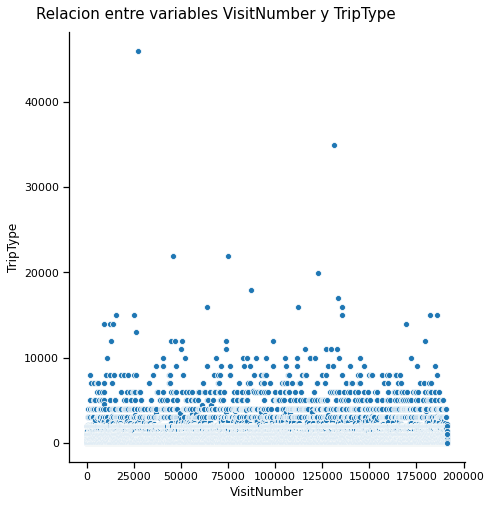

In [14]:
sns.set_context("notebook")
g = sns.pairplot(data=df, x_vars="VisitNumber", y_vars= "TripType")
g.fig.set_size_inches(8,8)
plt.subplots_adjust(top=0.95)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Relacion entre variables VisitNumber y TripType', fontsize=15, va="center")
plt.show()

No podemos detectar visualmente alguna tendencia de relacion entre los datos.


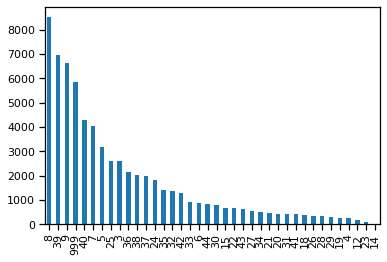

In [15]:
bins = set(original_df.TripType)
# to count the TripType values, we have to group the visits by VisitNumber
original_df.groupby("VisitNumber").TripType.mean().value_counts().plot(kind='bar')

Como sabemos que los datos estan desbalanceados, utilizaremos el modulo StandardScaler de scikit learn para estandarizar los datos y atenuar este desbalanceamiento:

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
ss = StandardScaler()
ss.fit(X_train)
ss.fit(X_valid)
x_train = ss.transform(X_train)
x_valid = ss.transform(X_valid)

Como primer modelo probamos un clasificador linear con 
descenso de gradiente estocástico con los parametros por default del SGDClassifier (SVM):

In [17]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=0)
model.fit(x_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)

In [19]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_valid, y_valid_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 0.59
Test accuracy: 0.59


Con este modelo, obtuvimos un accuracy de 0.59 que no supera a la del arbol de desicion propuesto en el baseline. Veamos si modificando los parametros obtenemos un mejor resultado:

In [20]:
from scipy import stats

param_grid = {
    'loss': ['hinge', 'log', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': stats.loguniform(1e-4, 1e0),
    #'max_iter': [7000, 10000, 50000, 10000000]
}

In [21]:
from sklearn.model_selection import RandomizedSearchCV

model = SGDClassifier(random_state=0)

cv = RandomizedSearchCV(model, param_grid, cv=3)
cv.fit(x_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=0, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'al

In [22]:
best_model = cv.best_estimator_
best_model

SGDClassifier(alpha=0.002156208997455722, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
best_model.fit(x_train, y_train)


SGDClassifier(alpha=0.002156208997455722, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
from sklearn.metrics import accuracy_score
y_train_pred = best_model.predict(x_train)
y_valid_pred = best_model.predict(x_valid)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_valid, y_valid_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 0.56
Test accuracy: 0.56


Como vemos el mejor modelo obtenido fue con una regresion logistica. Sin embargo no mejora el accuracy obtenido con el arbol de desicion propuesto en el baseline.


Probemos entonces un Clasificador RandomForest.

In [25]:
import numpy as np

from sklearn import tree
from sklearn import datasets
from sklearn import model_selection

import graphviz
from sklearn import ensemble

In [26]:
clf = ensemble.RandomForestClassifier(random_state=2)
clf.fit(x_train, y_train)
predictions = clf.predict(x_valid)
print ('Accuracy: %d ' % ((np.sum(y_valid == predictions))/float(y_valid.size)*100))

Accuracy: 64 


Con este modelo si obtuvimos mejores resultados. Veamos si haciendo una busqueda por grilla podemos optimizar y mejorar aun mas el modelo:

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 2, 3, 5, 8, 10),
              'min_samples_split':(2, 3, 5, 10, 25, 50, 100, 200)}

tree_clf = GridSearchCV(clf, tree_param, cv=3, scoring='accuracy') 
tree_clf.fit(x_train, y_train)
best_tree_clf = tree_clf.best_estimator_
print(best_tree_clf)
predictions = best_tree_clf.predict(x_valid)
print ('Accuracy: %d ' % ((np.sum(y_valid == predictions))/float(y_valid.size)*100))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)
Accuracy: 67 


Con este ultimo modelo obtenemos el valor de accuracy mas alto por lo que lo utilizaremos para generar el archivo de submission con los resultados de las predicciones de los valores de TripType obtenidos usando este modelo para los dados VisitNumber (XX). Este es el archivo que subiremos a Kaggle para participar de la competencia:

In [28]:
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)
yy = results.clf.iloc[0].predict(XX)
submission = pd.DataFrame(list(zip(XX.VisitNumber, yy)), columns=["VisitNumber", "TripType"])
submission.to_csv("submission.csv", header=True, index=False)